<a href="https://colab.research.google.com/github/t1p0kgod/DeepLearn/blob/main/work7/%D0%97%D0%BE%D0%BB%D0%BE%D1%82%D0%BA%D0%BE%D0%B2_%D0%A0%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_7_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Тема №7. Использование автоэнкодера для решения задач семантической сегментации. Часть 3

## **Задание:**

## Скачать датасет по ссылке (снимки и маски, Version 1) . Обучить нейронную сеть предсказывать полноразмерную маску по загруженному снимку (см. теорию к предыдущим частям работы)

### Ссылка на датасет: https://landcover.ai.linuxpolska.com/#dataset



# Этап 1. Обработка исходных данных. Разделение на обучающую и тестовую выборку

Для работы с tiff-изображениями предлагается использовать библиотеку tifffile

In [ ]:
!pip install -U -q segmentation-models
!pip install tifffile
!pip install patchify
!pip install imagecodecs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 32.0 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import glob
import imagecodecs

import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from keras.metrics import MeanIoU
import random

Segmentation Models: using `tf.keras` framework.


In [ ]:
print(tiff.__version__)
print(imagecodecs.__version__)
print(sm.__version__)

2023.4.12
2023.3.16
1.0.1


## 1.1. Проверка вывода растра и масок

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# temp_dir = '/content/drive/MyDrive/DEEP LEARN ^_^/landcover/'
temp_dir = '/content/drive/MyDrive/DEEP LEARN ^_^/landcover/'


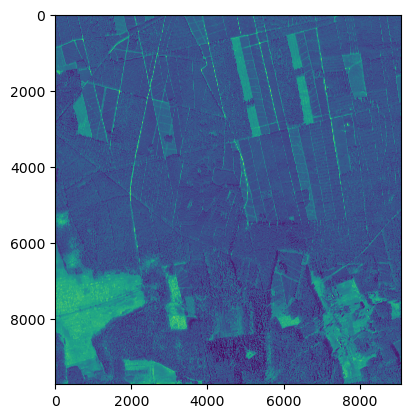

In [ ]:
temp_img = tiff.imread(temp_dir +"images/M-33-7-A-d-2-3.tif")
plt.imshow(temp_img[:,:,0])

(9711, 9081, 3)
uint8
(9711, 9081)
uint8
Labels are:  [0 1 2 4]  and the counts are:  [10649007    60415 75869435  1606734]


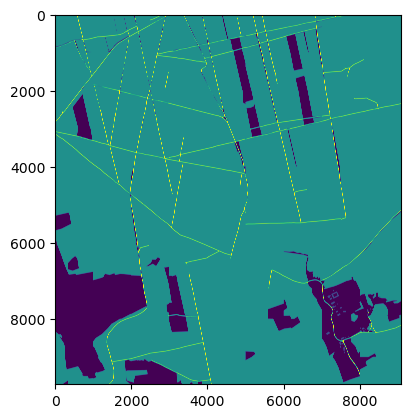

In [ ]:
temp_mask = tiff.imread(temp_dir +"masks/M-33-7-A-d-2-3.tif")
plt.imshow(temp_mask)

print(temp_img.shape)
print(temp_img.dtype)
print(temp_mask.shape)
print(temp_mask.dtype)

labels, count = np.unique(temp_mask, return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)

## 1.2. Обрезка исходных растров на фрагменты (патчи) размером 256x256. Сохраните их в каталог на локальное хранилице

In [ ]:
root_directory = ''

patch_size = 256

In [ ]:
img_dir=root_directory+"images/"
mask_dir=root_directory+"masks/"

In [ ]:
#Считываем изображения из подкаталога 'images'.
#Поскольку все изображения имеют разный размер, у нас есть 2 варианта: изменить размер или обрезать.
#Но некоторые изображения слишком большие, а некоторые маленькие. Изменение размера изменит размер реальных объектов.
#Поэтому мы обрезаем их до ближайшего размера, кратного 256, а затем 
#разделим все изображения на участки размером 256x256x3.
for path, subdirs, files in os.walk(img_dir):
    print(path)  
    dirname = path.split(os.path.sep)[-1]
    print(dirname)
    images = os.listdir(path) 
    print(images)
    for i, image_name in enumerate(images):  
        if image_name.endswith(".tif"):
            
            image = tiff.imread(path+"/"+ image_name)
            
            SIZE_X = (image.shape[1]//patch_size)*patch_size 
            SIZE_Y = (image.shape[0]//patch_size)*patch_size 
          
            image = image[0:SIZE_Y, 0:SIZE_X]

            print("Now patchifying image:", path+"/"+image_name)
            patches_img = patchify(image, (256, 256, 3), step=256)
            
            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    
                    single_patch_img = patches_img[i,j,:,:]
                    single_patch_img = single_patch_img[0]
          
                    tiff.imwrite(root_directory+"256_patches/images/" + image_name[:-4] + 
                                 "patch_" + str(i) + str(j) + ".tif", single_patch_img, photometric='rgb')
            

## 1.3. Обрезка исходных масок на фрагменты (патчи) размером 256x256. Сохраните их в каталог на локальное хранилице

In [ ]:
for path, subdirs, files in os.walk(mask_dir):
    print(path)  
    dirname = path.split(os.path.sep)[-1]

    masks = os.listdir(path)
    for i, mask_name in enumerate(masks):  
        if mask_name.endswith(".tif"):  
            
            mask = cv2.imread(path + "/" + mask_name) 


            SIZE_X = (mask.shape[1]//patch_size)*patch_size 
            SIZE_Y = (mask.shape[0]//patch_size)*patch_size 

            mask = mask[0:SIZE_Y, 0:SIZE_X] 
            print("Now patchifying mask:", path+"/"+mask_name)
            patches_mask = patchify(mask, (256, 256, 1), step=256)  
    
            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):
                    
                    single_patch_mask = patches_mask[i,j,:,:]
                    single_patch_mask = single_patch_mask[0]
                    tiff.imwrite(root_directory + "256_patches/masks/" +
                               mask_name[:-4] + "patch_" + str(i) + str(j) + ".tif", single_patch_mask, photometric='minisblack')


## 1.4. Проверка патчей масок и исходного растра на соответствие

In [ ]:
img_dir_patched = root_directory +'256_patches/images/'
mask_dir_patched = root_directory +'256_patches/masks/'

image_test = tiff.imread(img_dir_patched + "M-33-7-A-d-2-3patch_00.tif")
mask_test = tiff.imread(mask_dir_patched + "M-33-7-A-d-2-3patch_00.tif")

plt.imshow(image_test)

NameError: ignored

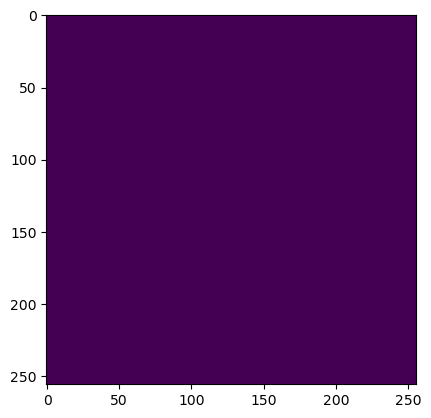

In [ ]:
plt.imshow(mask_test)

## 1.5. Отсев неинформативных растров и соответствующих масок

Пропускаем изображения на которых один класс заднимает более 95% площади

In [ ]:
# Скопируем изображения и маски с реальной информацией в новую папку.
img_list = os.listdir(img_dir_patched)
msk_list = os.listdir(mask_dir_patched)
print(img_list)
train_img_dir = root_directory + "useful_images/images/"
train_mask_dir = root_directory + "useful_images/masks/"

useless=0
for img in range(len(img_list)): 
    img_name=img_list[img]
    mask_name = msk_list[img]
    print("Now preparing image and masks number: ", img)
    temp_image=tiff.imread(img_dir_patched + img_list[img])
   
    temp_mask=tiff.imread(mask_dir_patched+msk_list[img])
    #temp_mask=temp_mask.astype(np.uint8)
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.05:  # От 5% полезной площади
        tiff.imwrite(train_img_dir + img_name, temp_image, photometric='rgb')
        tiff.imwrite(train_mask_dir + mask_name, temp_mask, photometric='rgb')
        
    else:
        useless +=1

print("Total useful images are: ", len(img_list) - useless) 
print("Total useless images are: ", useless) 

## 1.6. Формирование папок с обучающей и валидационной выборкой

In [ ]:
!pip install split-folders


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import splitfolders  # or import split_folders

input_folder = root_directory + "useful_images/"
output_folder = root_directory + "train_test_data/"

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) 

Copying files: 29648 files [05:23, 91.67 files/s] 


# Этап 2. Загрузка тренировочной и тестовой выборки. Подготовка к обучению. Разработка архитектуры модели нейронной сети

In [ ]:
# Подключаем необходимые модули и пакеты
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import cv2
from google.colab.patches import cv2_imshow
import os

## 2.1. Инициализация сформированной выборки

In [ ]:
root_directory = "/content/drive/MyDrive/DEEP LEARN ^_^/"

train_images_dir = root_directory + "train_test_data/train_images/" 
train_masks_dir = root_directory + "train_test_data/train_masks/"
val_images_dir = root_directory + "train_test_data/val_images/" 
val_masks_dir = root_directory +"train_test_data/val_masks/"

#### Проверка

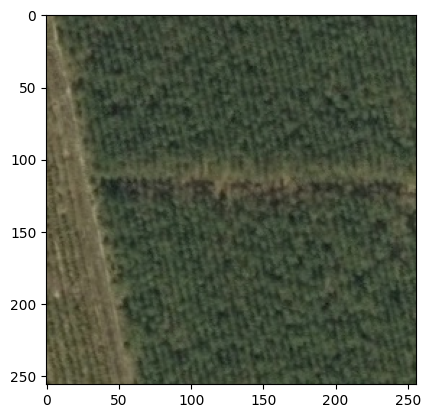

In [ ]:
image_test = tiff.imread(train_images_dir + "images/M-33-7-A-d-2-3patch_07.tif")
plt.imshow(image_test)

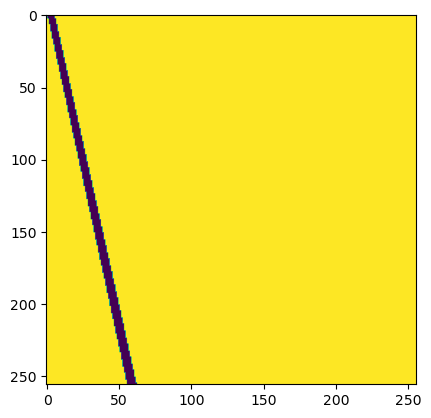

In [ ]:
mask_test = tiff.imread(train_masks_dir + "masks/M-33-7-A-d-2-3patch_07.tif")
plt.imshow(mask_test)

## 2.2. Предобработка обучающей выборки

Обратите внимание на формат масок в датасете. Возможно для решения этой задачи нет необходимости изменять исходные значения пикселей в маске.

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical

#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)



### Нормализация исходного патча и маски

In [ ]:
def preprocess_data(img, mask, num_class):
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img) 
    mask = mask[:,:,:,0]
    mask = to_categorical(mask, num_class)
      
    return (img, mask)

## 2.3. Формирование последовательной загрузки набора данных с жесткого диска для обучения модели, используя Keras.ImageDataGenerator()

In [ ]:
seed=24
batch_size= 16
n_classes=6

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True)
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [ ]:
train_img_gen = trainGenerator(train_images_dir, train_masks_dir, num_class=n_classes)
val_img_gen = trainGenerator(val_images_dir, val_masks_dir, num_class=n_classes)

In [ ]:
print(train_images_dir)
print(train_masks_dir)
print(val_images_dir)
print(val_masks_dir)

In [ ]:
num_train_imgs = len(os.listdir(train_images_dir+'images/'))
num_val_images = len(os.listdir(val_images_dir+'images/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

print("training images count:",num_train_imgs)
print("validation images count:",num_val_images)
print("training step per epoch :",steps_per_epoch)
print("validation step per epoch:",val_steps_per_epoch)


training images count: 11118
validation images count: 3706
training step per epoch : 694
validation step per epoch: 231


In [ ]:
x,y= next(train_img_gen)
x_val,y_val= next(val_img_gen)

Found 11118 images belonging to 1 classes.
Found 11118 images belonging to 1 classes.


UnidentifiedImageError: ignored

#### Проверка:

In [ ]:
for i in range(0,3):
    image = x[i][:,:,0]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

for i in range(0,3):
    image = x_val[i][:,:,0]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

labels, count = np.unique(mask, return_counts=True) #Check for each channel. All chanels are identical

print("Unique labels in label dataset are: ", np.unique(labels))

NameError: ignored

## 2.4. Разработка архитектуры и компиляция модели

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred): # https://ru.wikipedia.org/wiki/Коэффициент_Жаккара
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

metrics=['accuracy', jacard_coef, sm.metrics.iou_score, sm.metrics.precision, sm.metrics.recall]

### Параметры модели:

In [ ]:
from keras.models import Model
from keras.callbacks import CSVLogger
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
import pickle

model_landcover = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')
model_landcover.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics, run_eagerly=True)

# checkpoint_path = "/checkpoints/backbone/model_landcover.ckpt"

# csv_callback = CSVLogger("/model_landcover_log.csv", append=True),

# Create a callback that saves the model's weights
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
# print(model_resnet_backbone.summary())

# Этап 3. Обучение модели и оценка точности

In [ ]:
history = model_landcover.fit(
          train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=50,
          verbose=1,
          # callbacks = [csv_callback, cp_callback],
          validation_data= val_img_gen,
          validation_steps=val_steps_per_epoch
          )

StopIteration: ignored

## 3.1. Визуализация процесса обучения

In [ ]:
with open("model_landcover.ckpt",'wb') as f:
    pickle.dump(history,f)

In [ ]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(50, acc, 'y', label='Training IoU')
plt.plot(50, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

## 3.2. Оценка оценка точности по валидационной выборке

In [ ]:
model_landcover.evaluate(train_img_gen, val_img_gen, batch_size=32)

## 3.3. Визуализация предсказаний и сравнение их с оригинальными масками

In [ ]:
from imutils import paths
import cv2
import numpy as np

images = []
masks = []
images_path = ['M-33-7-A-d-2-3patch_11.tif',
          'M-33-7-A-d-2-3patch_07.tif',
          'M-33-7-A-d-2-3patch_08.tif']
masks_path = ['M-33-7-A-d-2-3patch_011.tif',
          'M-33-7-A-d-2-3patch_07.tif',
          'M-33-7-A-d-2-3patch_08.tif']
for i in range(3):
  train_img_path= root_directory + f'train_test_data/train_images/images/{images_path[i]}'
  train_mask_path = root_directory + f'train_test_data/train_masks/masks/{masks_path[i]}'

  images.append(tiff.imread(train_img_path))
  original_mask = tiff.imread(train_mask_path)
  # original_mask = cv2.cvtColor(original_mask, cv2.COLOR_BGR2RGB)
  masks.append(original_mask)
print(np.shape(images),np.shape(masks))

(3, 256, 256, 3) (3, 256, 256, 1)


In [ ]:
patch_size = 256

n_classes = 6

In [ ]:
def plot_images(orig_mask, predicted_mask):
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.title('Orig mask', color = 'green', fontsize = 20)
    plt.imshow(orig_mask)
    plt.subplot(1,2,2)
    plt.title('Pred mask ', color = 'black', fontsize = 20)
    plt.imshow(predicted_mask)
   
    plt.show()

for i in range(len(images)):
  orig_mask = masks[i]
  mask_predict = model_landcover.predict(images[i])

  plot_images(orig_mask,mask_predict)

# Этап 4. Обработка цельного снимка с помощью обученной модели

In [ ]:
"""

Original code is from the following source. It comes with MIT License so please mention
the original reference when sharing.

The original code has been modified to fix a couple of bugs and chunks of code
unnecessary for smooth tiling are removed. 

# MIT License
# Copyright (c) 2017 Vooban Inc.
# Coded by: Guillaume Chevalier
# Source to original code and license:
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches/blob/master/LICENSE

"""
"""Perform smooth predictions on an image from tiled prediction patches."""


import numpy as np
import scipy.signal
from tqdm import tqdm

import gc


if __name__ == '__main__':
    import matplotlib.pyplot as plt
    PLOT_PROGRESS = False
    # See end of file for the rest of the __main__.
else:
    PLOT_PROGRESS = False


def _spline_window(window_size, power=2):
    """
    Squared spline (power=2) window function:
    https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2
    """
    intersection = int(window_size/4)
    wind_outer = (abs(2*(scipy.signal.triang(window_size))) ** power)/2
    wind_outer[intersection:-intersection] = 0

    wind_inner = 1 - (abs(2*(scipy.signal.triang(window_size) - 1)) ** power)/2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0

    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    return wind


cached_2d_windows = dict()
def _window_2D(window_size, power=2):
    """
    Make a 1D window function, then infer and return a 2D window function.
    Done with an augmentation, and self multiplication with its transpose.
    Could be generalized to more dimensions.
    """
    # Memoization
    global cached_2d_windows
    key = "{}_{}".format(window_size, power)
    if key in cached_2d_windows:
        wind = cached_2d_windows[key]
    else:
        wind = _spline_window(window_size, power)
        wind = np.expand_dims(np.expand_dims(wind, 1), 1)      #SREENI: Changed from 3, 3, to 1, 1 
        wind = wind * wind.transpose(1, 0, 2)
        if PLOT_PROGRESS:
            # For demo purpose, let's look once at the window:
            plt.imshow(wind[:, :, 0], cmap="viridis")
            plt.title("2D Windowing Function for a Smooth Blending of "
                      "Overlapping Patches")
            plt.show()
        cached_2d_windows[key] = wind
    return wind


def _pad_img(img, window_size, subdivisions):
    """
    Add borders to img for a "valid" border pattern according to "window_size" and
    "subdivisions".
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    more_borders = ((aug, aug), (aug, aug), (0, 0))
    ret = np.pad(img, pad_width=more_borders, mode='reflect')
    # gc.collect()

    if PLOT_PROGRESS:
        # For demo purpose, let's look once at the window:
        plt.imshow(ret)
        plt.title("Padded Image for Using Tiled Prediction Patches\n"
                  "(notice the reflection effect on the padded borders)")
        plt.show()
    return ret


def _unpad_img(padded_img, window_size, subdivisions):
    """
    Undo what's done in the `_pad_img` function.
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    ret = padded_img[
        aug:-aug,
        aug:-aug,
        :
    ]
    # gc.collect()
    return ret


def _rotate_mirror_do(im):
    """
    Duplicate an np array (image) of shape (x, y, nb_channels) 8 times, in order
    to have all the possible rotations and mirrors of that image that fits the
    possible 90 degrees rotations.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    return mirrs


def _rotate_mirror_undo(im_mirrs):
    """
    merges a list of 8 np arrays (images) of shape (x, y, nb_channels) generated
    from the `_rotate_mirror_do` function. Each images might have changed and
    merging them implies to rotated them back in order and average things out.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return np.mean(origs, axis=0)


def _windowed_subdivs(padded_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Create tiled overlapping patches.
    Returns:
        5D numpy array of shape = (
            nb_patches_along_X,
            nb_patches_along_Y,
            patches_resolution_along_X,
            patches_resolution_along_Y,
            nb_output_channels
        )
    Note:
        patches_resolution_along_X == patches_resolution_along_Y == window_size
    """
    WINDOW_SPLINE_2D = _window_2D(window_size=window_size, power=2)

    step = int(window_size/subdivisions)
    padx_len = padded_img.shape[0]
    pady_len = padded_img.shape[1]
    subdivs = []

    for i in range(0, padx_len-window_size+1, step):
        subdivs.append([])
        for j in range(0, pady_len-window_size+1, step):            #SREENI: Changed padx to pady (Bug in original code)
            patch = padded_img[i:i+window_size, j:j+window_size, :]
            subdivs[-1].append(patch)

    # Here, `gc.collect()` clears RAM between operations.
    # It should run faster if they are removed, if enough memory is available.
    gc.collect()
    subdivs = np.array(subdivs)
    gc.collect()
    a, b, c, d, e = subdivs.shape
    subdivs = subdivs.reshape(a * b, c, d, e)
    gc.collect()

    subdivs = pred_func(subdivs)
    gc.collect()
    subdivs = np.array([patch * WINDOW_SPLINE_2D for patch in subdivs])
    gc.collect()

    # Such 5D array:
    subdivs = subdivs.reshape(a, b, c, d, nb_classes)
    gc.collect()

    return subdivs


def _recreate_from_subdivs(subdivs, window_size, subdivisions, padded_out_shape):
    """
    Merge tiled overlapping patches smoothly.
    """
    step = int(window_size/subdivisions)
    padx_len = padded_out_shape[0]
    pady_len = padded_out_shape[1]

    y = np.zeros(padded_out_shape)

    a = 0
    for i in range(0, padx_len-window_size+1, step):
        b = 0
        for j in range(0, pady_len-window_size+1, step):                #SREENI: Changed padx to pady (Bug in original code)
            windowed_patch = subdivs[a, b]
            y[i:i+window_size, j:j+window_size] = y[i:i+window_size, j:j+window_size] + windowed_patch
            b += 1
        a += 1
    return y / (subdivisions ** 2)


def predict_img_with_smooth_windowing(input_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Apply the `pred_func` function to square patches of the image, and overlap
    the predictions to merge them smoothly.
    See 6th, 7th and 8th idea here:
    http://blog.kaggle.com/2017/05/09/dstl-satellite-imagery-competition-3rd-place-winners-interview-vladimir-sergey/
    """
    pad = _pad_img(input_img, window_size, subdivisions)
    pads = _rotate_mirror_do(pad)

    # Note that the implementation could be more memory-efficient by merging
    # the behavior of `_windowed_subdivs` and `_recreate_from_subdivs` into
    # one loop doing in-place assignments to the new image matrix, rather than
    # using a temporary 5D array.

    # It would also be possible to allow different (and impure) window functions
    # that might not tile well. Adding their weighting to another matrix could
    # be done to later normalize the predictions correctly by dividing the whole
    # reconstructed thing by this matrix of weightings - to normalize things
    # back from an impure windowing function that would have badly weighted
    # windows.

    # For example, since the U-net of Kaggle's DSTL satellite imagery feature
    # prediction challenge's 3rd place winners use a different window size for
    # the input and output of the neural net's patches predictions, it would be
    # possible to fake a full-size window which would in fact just have a narrow
    # non-zero dommain. This may require to augment the `subdivisions` argument
    # to 4 rather than 2.

    res = []
    for pad in tqdm(pads):
        # For every rotation:
        sd = _windowed_subdivs(pad, window_size, subdivisions, nb_classes, pred_func)
        one_padded_result = _recreate_from_subdivs(
            sd, window_size, subdivisions,
            padded_out_shape=list(pad.shape[:-1])+[nb_classes])

        res.append(one_padded_result)

    # Merge after rotations:
    padded_results = _rotate_mirror_undo(res)

    prd = _unpad_img(padded_results, window_size, subdivisions)

    prd = prd[:input_img.shape[0], :input_img.shape[1], :]

    if PLOT_PROGRESS:
        plt.imshow(prd)
        plt.title("Smoothly Merged Patches that were Tiled Tighter")
        plt.show()
    return prd

In [ ]:
image_dir = '/content/drive/MyDrive/DEEP LEARN ^_^/Dataset/M-34-65-D-a-4-4_crop.tif'
mask_path = '/content/drive/MyDrive/DEEP LEARN ^_^/Dataset/M-34-65-D-a-4-4_cropped.tif'

In [ ]:
# !pip install -U -q segmentation-models
# !pip install tifffile
# !pip install patchify
!pip install imagecodecs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tifffile==2022.5.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import skimage.io as skio
imstack1 = skio.imread(image_dir, plugin="tifffile")

from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import tifffile as tiff
import imagecodecs
# unet_landcover = load_model("unet_landcover.h5", compile=False)
unet_landcover = load_model("/content/drive/MyDrive/DEEP LEARN ^_^/model_resnet_backbone_1.h5", compile=False)

scaler = MinMaxScaler()

patch_size = 256
n_classes = 6
my_unet_predictions = []

# for image_path in image_dir:
img = tiff.imread(image_dir)  
input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
predictions_smooth = predict_img_with_smooth_windowing(
    input_img,
    window_size=patch_size,
    subdivisions=2,
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: unet_landcover.predict((img_batch_subdiv))
    )
)

final_prediction = np.argmax(predictions_smooth, axis=2)
my_unet_predictions.append(final_prediction)

  0%|          | 0/8 [00:00<?, ?it/s]

9/9 [==============================] - 16s 498ms/step


 12%|█▎        | 1/8 [00:19<02:17, 19.64s/it]

9/9 [==============================] - 1s 123ms/step


 25%|██▌       | 2/8 [00:26<01:13, 12.18s/it]

9/9 [==============================] - 1s 121ms/step


 38%|███▊      | 3/8 [00:32<00:45,  9.12s/it]

9/9 [==============================] - 1s 123ms/step


 50%|█████     | 4/8 [00:37<00:30,  7.64s/it]

9/9 [==============================] - 1s 125ms/step


 62%|██████▎   | 5/8 [00:43<00:21,  7.15s/it]

9/9 [==============================] - 1s 124ms/step


 75%|███████▌  | 6/8 [00:50<00:13,  6.94s/it]

9/9 [==============================] - 1s 123ms/step


 88%|████████▊ | 7/8 [00:57<00:07,  7.09s/it]

9/9 [==============================] - 1s 124ms/step


100%|██████████| 8/8 [01:04<00:00,  8.01s/it]


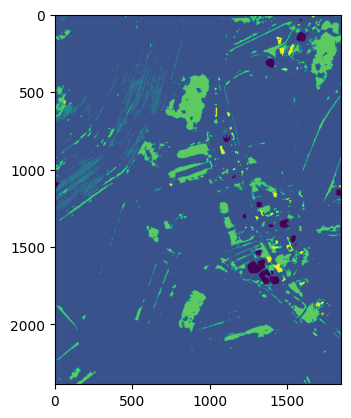

In [ ]:
import cv2
import os
#предсказанная
prediction = my_unet_predictions[0]
plt.imshow(prediction)

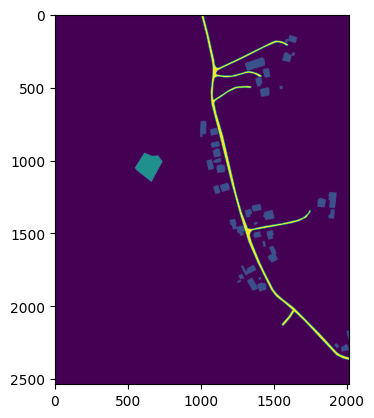

In [ ]:
#маска
temp_mask = tiff.imread(mask_path)
plt.imshow(temp_mask[:,:,0])

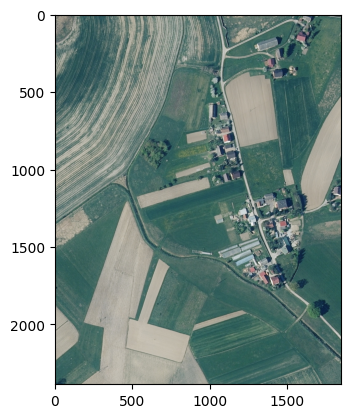

In [ ]:
#оригинальное изображение
temp_mask = tiff.imread(image_dir)
plt.imshow(temp_mask)

См. предыдущую часть работы